In [1]:
import os
import pandas as pd
from GraphBuild import * 
import matplotlib.pyplot as plt
import random
import pickle

In [2]:
# Initialize Circuit
FolderName = os.path.dirname(os.path.realpath("__file__"))
DSSfile = r""+ FolderName+ "\ieee34Mod1.dss"
Ckt_obj = CircuitSetup(DSSfile)  #creating a DSS object instance
G_original =  build_graph(Ckt_obj)
nx.readwrite.gml.write_gml(G_original,"34busEx.gml") #Graph undirected with edge features and node features which are constant

In [3]:
node_list=list(G_original.nodes())
edge_list=list(G_original.edges())

In [4]:
input_file = 'LoadShape1.xlsx'
sheet_name = 'LoadShape1'  # Change to the sheet you want to split
df = pd.read_excel(input_file, sheet_name=sheet_name)

points_per_day = 24  # Assuming 1-hour resolution (24 points = 24 hours)
# Convert to flat list
loadshape_values = df.iloc[:, 0].values.tolist()
# Check total number of complete days available
num_days = len(loadshape_values) // points_per_day
# Slice the loadshape into daily
LoadShapes = []
for i in range(num_days):
    start_idx = i * points_per_day
    end_idx = (i + 1) * points_per_day
    daily_shape = loadshape_values[start_idx:end_idx]
    LoadShapes.append(daily_shape)

In [5]:
Ckt_obj.dss.Text.Command(f"New LoadShape.LoadVar")

###  Normal Scenarios -- Time Series

In [6]:
Scenarios  = []
scid = 0
### Scenario generation
NSc = 1 # parameter indicating no.of scenarios for each

In [7]:
def Powerflow_Timeseries(Ckt_obj, loadshape_day):
    # Edit the LoadShape in opendss
    Ckt_obj.dss.Text.Command(f"Edit LoadShape.LoadVar npts={len(loadshape_day)} interval=1 mult=(" + ' '.join(map(str, loadshape_day)) + ")")
    # Assign Load shapes
    Ckt_obj.dss.Text.Command("BatchEdit Load..* daily=LoadVar")
    
    # Time-series simulation        
    V_node_Sc = {bus: [] for bus in node_list}
    flow_branch_Sc= {br: [] for br in edge_list}
    
    Ckt_obj.dss.Text.Command("Set mode=daily")
    Ckt_obj.dss.Text.Command("Set stepsize=30m")
    Ckt_obj.dss.Text.Command("Set number=1")
    t= 0
    while t<24:
            Ckt_obj.dss.Solution.Solve()
            # Get Node Voltages
            for bus in node_list:
                V=Bus(Ckt_obj,bus).Vmag
                V_node_Sc[bus].append(V) 
                
            # Get branchflows  
            for (u,v) in edge_list:
                branch_label = G_original[u][v]['Label']
                branch_device = G_original[u][v]['Device']
                branch_elem = f"{branch_device}.{branch_label}"
                branch_pflow = Branch(Ckt_obj,branch_elem).flow
                branchflow = np.sum(branch_pflow)
                flow_branch_Sc[(u,v)].append(branchflow)
        
            t = Ckt_obj.dss.Solution.DblHour()
        
    return  V_node_Sc, flow_branch_Sc
    

### Check under/over laoding

In [8]:
# Applying overloading or under loading to loadshape for normal operations
loadshape_day = random.choice(LoadShapes)

In [9]:
random.choice([0,1])

0

In [10]:
loadvar_factor = random.uniform(1.1, 1.5) # Overload
loadvar_factor = random.uniform(0.3, 0.9) # Underload

In [11]:
variedloadedshape = loadshape_day.copy()

In [12]:
total_steps = 24
start_idx = random.randint(0, total_steps - 1)
max_length = total_steps - start_idx  
loadvar_length = random.randint(1, min(6, max_length)) # Ensure don't exceed total steps
# Compute end index
end_idx = start_idx + loadvar_length 

In [13]:
for i in range(start_idx, end_idx):
    variedloadedshape[i] = variedloadedshape[i] * loadvar_factor

In [14]:
V_node_Sc1, flow_branch_Sc1 = Powerflow_Timeseries(Ckt_obj, loadshape_day)

In [15]:
V_node_Sc2, flow_branch_Sc2 = Powerflow_Timeseries(Ckt_obj, variedloadedshape)

In [16]:
target_bus = '890'

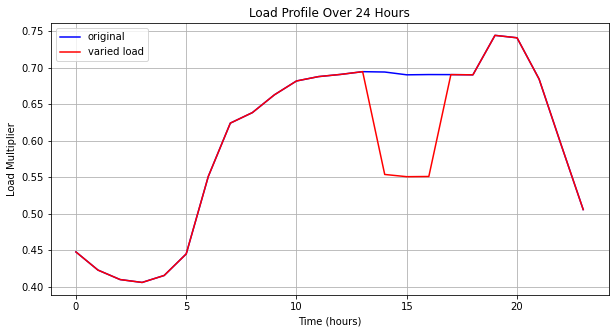

In [17]:
# Plot both load shapes
plt.figure(figsize=(10,5))
plt.plot(range(24), loadshape_day, label="original", color='blue')
plt.plot(range(24), variedloadedshape, label="varied load", color='red')
plt.xlabel("Time (hours)")
plt.ylabel("Load Multiplier")
plt.title("Load Profile Over 24 Hours")
plt.grid(True)
plt.legend()
plt.show()

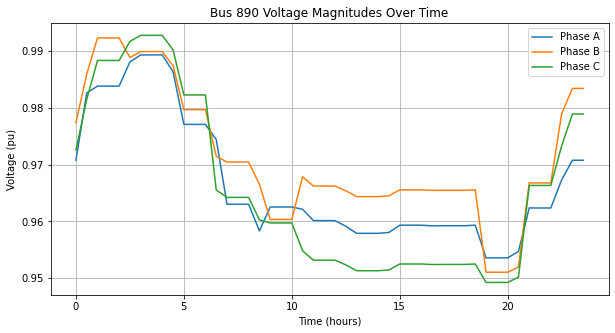

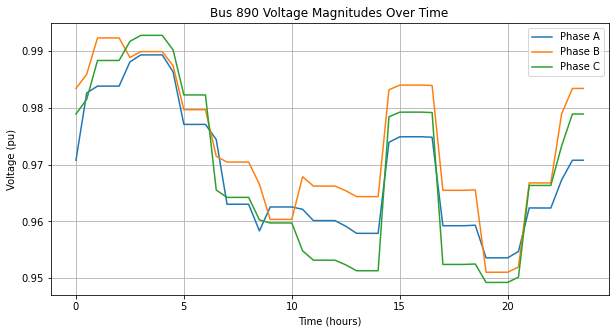

In [18]:
times = [0.5*i for i in range(len(V_node_Sc1[target_bus]))]
# -- Plot 1: 3-Phase Voltage Magnitudes over Time --
plt.figure(figsize=(10,5))
plt.plot(times, [v[0] for v in V_node_Sc1[target_bus]], label="Phase A")
plt.plot(times, [v[1] for v in V_node_Sc1[target_bus]], label="Phase B")
plt.plot(times, [v[2] for v in V_node_Sc1[target_bus]], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus {target_bus} Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()

# -- Plot 1: 3-Phase Voltage Magnitudes over Time --
plt.figure(figsize=(10,5))
plt.plot(times, [v[0] for v in V_node_Sc2[target_bus]], label="Phase A")
plt.plot(times, [v[1] for v in V_node_Sc2[target_bus]], label="Phase B")
plt.plot(times, [v[2] for v in V_node_Sc2[target_bus]], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus {target_bus} Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()

### Normal Scenario generation

In [19]:
for idx in range(NSc):
    # Varying Load shapes
    loadshape_day = random.choice(LoadShapes)
    V_node_Sc, flow_branch_Sc = Powerflow_Timeseries(Ckt_obj, loadshape_day)
    Scenarios.append({'Index':scid, 'Anomalous':'No', 'Targeted Buses': [], 'Attack Type': 'Nil', 'BusVoltage series':V_node_Sc,'BranchFlow series':flow_branch_Sc})
    scid = scid + 1

In [20]:
target_bus = '850'

In [21]:
times = [0.5*i for i in range(len(V_node_Sc[target_bus]))]

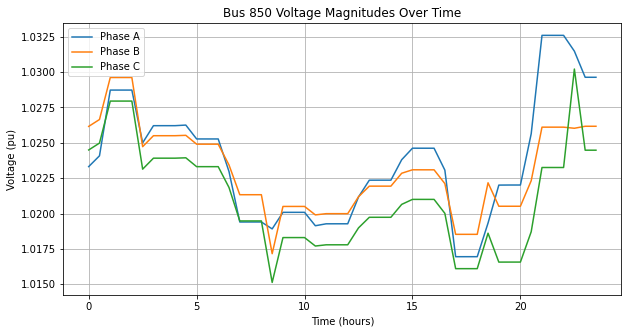

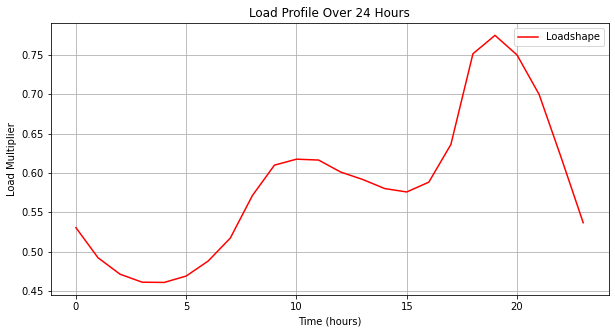

In [22]:
# -- Plot 1: 3-Phase Voltage Magnitudes over Time --
plt.figure(figsize=(10,5))
plt.plot(times, [v[0] for v in V_node_Sc[target_bus]], label="Phase A")
plt.plot(times, [v[1] for v in V_node_Sc[target_bus]], label="Phase B")
plt.plot(times, [v[2] for v in V_node_Sc[target_bus]], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus {target_bus} Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()

# Plot
plt.figure(figsize=(10,5))
plt.plot(range(24), loadshape_day, label="Loadshape", color='red')
plt.xlabel("Time (hours)")
plt.ylabel("Load Multiplier")
plt.title("Load Profile Over 24 Hours")
plt.grid(True)
plt.legend()
plt.show()

In [23]:
def inject_voltage_attack(BusVoltages, start_idx, end_idx, attack_mult):
    for i in range(start_idx, end_idx):
        BusVoltages[i] = [v * attack_mult for v in BusVoltages[i]] #array if necessary
    return BusVoltages

### Scenarios for Attacks

In [60]:
## Single Under voltage
for idx in range(NSc):
    # Varying Load shapes
    loadshape_day = random.choice(LoadShapes)
    V_node_Sc, flow_branch_Sc = Powerflow_Timeseries(Ckt_obj, loadshape_day)
    # Vary factor - under or over voltage
    attack_mult = random.uniform(0,0.85) # Under Voltage
    #attack_mult = random.uniform(1.05,1.3) # Over Voltage
    
    # Vary attack window
    total_steps = 48 #24 hours with 30 minutes
    # Min attack window is 2 steps 1 hour and max is 12 steps - 6 hours
    # Choose a random start index
    start_idx = random.randint(0, total_steps - 1)
    max_attack_length = total_steps - start_idx  
    attack_length = random.randint(2, min(12, max_attack_length)) # Ensure don't exceed total steps
    # Compute end index
    end_idx = start_idx + attack_length
    # Single attacks
    #num_nodes = 1
    #attack_buses = random.sample(node_list, k=num_nodes)
    # Multi attacks
    num_nodes = random.randint(1, 5)
    attack_buses = random.sample(node_list, k=num_nodes)     
    for atk_bus in attack_buses:
        VoltagesPre=V_node_Sc[atk_bus].copy()
        attacked_voltages = inject_voltage_attack(V_node_Sc[atk_bus], start_idx, end_idx, attack_mult)
#         V_node_Sc[atk_bus] = attacked_voltages
    Scenarios.append({'Index':scid, 'Anomalous':'Yes', 'Targeted Buses': attack_buses, 'Attack Type': 'Under Voltage', 'BusVoltage series':attacked_voltages,'BranchFlow series':flow_branch_Sc})
    scid = scid + 1

In [61]:
attack_buses

['sourcebus', '848', '824', '818', '852r']

In [62]:
times  = [i * 0.5 for i in range(len(attacked_voltages))] 

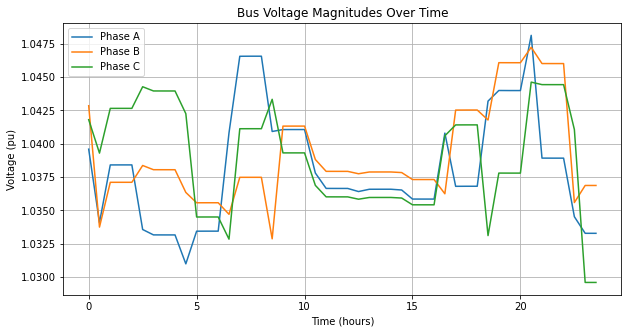

In [63]:
# Plot
plt.figure(figsize=(10,5))
# plt.plot(times, [v[0] for v in attacked_voltages], label="Phase A attack")
# plt.plot(times, [v[1] for v in attacked_voltages], label="Phase B attack")
# plt.plot(times, [v[2] for v in attacked_voltages], label="Phase C attack")
plt.plot(times, [v[0] for v in VoltagesPre], label="Phase A")
plt.plot(times, [v[1] for v in VoltagesPre], label="Phase B")
plt.plot(times, [v[2] for v in VoltagesPre], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()

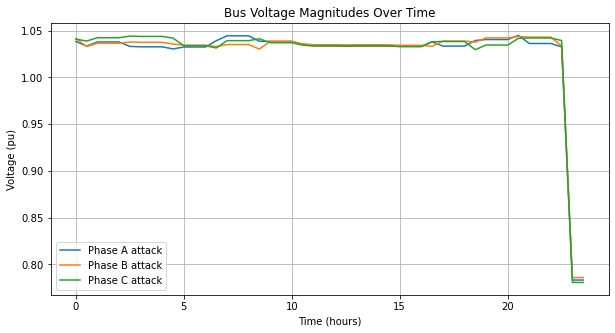

In [67]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(times, [v[0] for v in V_node_Sc['848']], label="Phase A attack")
plt.plot(times, [v[1] for v in V_node_Sc['848']], label="Phase B attack")
plt.plot(times, [v[2] for v in V_node_Sc['848']], label="Phase C attack")
# plt.plot(times, [v[0] for v in VoltagesPre], label="Phase A")
# plt.plot(times, [v[1] for v in VoltagesPre], label="Phase B")
# plt.plot(times, [v[2] for v in VoltagesPre], label="Phase C")
plt.xlabel("Time (hours)")
plt.ylabel("Voltage (pu)")
plt.title(f"Bus Voltage Magnitudes Over Time")
plt.grid(True)
plt.legend()
plt.show()

In [42]:
start_idx/2

21.0

In [43]:
end_idx/2

22.0

In [44]:
attack_mult

0.5480169779800826